In [13]:
# Modules to Import
import re
from io import BytesIO
from typing import List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pypdf import PdfReader
import pandas as pd
from EvaluateChatBotOnlyAnswerContext import EvalChatBot
from ChatBot import ChatBot
from langchain.docstore.document import Document
from giskard.rag import generate_testset
from giskard.rag import KnowledgeBase
from datasets import Dataset, Features, Sequence, Value
from ragas import evaluate

In [14]:

def parse_pdf(file: BytesIO) -> List[str]:
    '''
    preprocessing file pdf.
    input: pdf file path
    
    return: list of string
    '''
    pdf = PdfReader(file) #! read content from pdf
    output = []
    #print(pdf.pages) # pdf.pages will result a list of pages type
    for page in pdf.pages:
        text = page.extract_text() #! get text in each page
        # Merge word which contant dash in the middle. Ex: a-b
        text = re.sub(r"(\w+)-\n(\w+)", r"\1\2", text)
        # Fix newlines in the middle of sentences
        text = re.sub(r"(?<!\n\s)\n(?!\s\n)", " ", text.strip())
        # Remove multiple newlines
        text = re.sub(r"\n\s*\n", "\n\n", text)
        output.append(text)
    return output

def text_to_docs(text: str) -> List[Document]:
    """
    Converts a string or list of strings to a list of Documents
    with metadata.
    """
    if isinstance(text, str): 
        #! this condition is important because related to response of model accuracy
        # Take a single string as one page
        text = [text]
    page_docs = [Document(page_content=page) for page in text]

    # Add page numbers as metadata
    for i, doc in enumerate(page_docs):
        doc.metadata["page"] = i + 1

    # Split pages into chunks
    doc_chunks = []

    for doc in page_docs:
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size = 7000, #! this parameter has been experiment and evaluate so i can conclude chunk size is 7000
            separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
            chunk_overlap=0,
        )
        chunks = text_splitter.split_text(doc.page_content)
        for i, chunk in enumerate(chunks):
            doc = Document(
                page_content=chunk, metadata={"page": doc.metadata["page"], "chunk": i}
            )
            # Add sources a metadata
            doc.metadata["source"] = f"{doc.metadata['page']}-{doc.metadata['chunk']}"
            doc_chunks.append(doc)
    return doc_chunks

#! --------------------- generate test set ----------------------------------------
uploaded_file = "../../pdfData/Cells and Chemistry of Life.pdf"
doc = parse_pdf(uploaded_file)
documentList = text_to_docs(doc)

df = pd.DataFrame([d.page_content for d in documentList], columns=["text"])
knowledge_base = KnowledgeBase(df)
testset = generate_testset(
    knowledge_base,
    num_questions = 20,
    agent_description = "A chatbot answer all questions related to data" #! can be fine tune for better performance
)


test_set_df = testset.to_pandas()        

2024-09-09 23:34:31,589 pid:10552 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2024-09-09 23:34:37,625 pid:10552 MainThread giskard.rag  INFO     Found 3 topics in the knowledge base.


Generating questions:   0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
test_set_df

,question,reference_answer,reference_context,conversation_history,metadata
id,,,,,
bf0c697d-b5c5-4263-8f63-1f7011c62de4,What tests can be performed to identify differ...,To test a food for presence of reducing sugars...,Document 26: Chapter 3 Cells and the Chemistry...,[],"{'question_type': 'simple', 'seed_document_id'..."
bb208a0b-469d-43f5-98f6-3c3889d4d13e,What is the optimum pH for the activity of pro...,The optimum pH for the activity of protease in...,Document 33: 68 Chapter 4 Cells and the Chemis...,[],"{'question_type': 'simple', 'seed_document_id'..."
86d919bd-e927-4c28-a143-426fc83e26fb,What are enzymes and where can they be found?,Enzymes are biological catalysts. They can be ...,Document 27: 56 Chapter 3 Cells and the Chemis...,[],"{'question_type': 'simple', 'seed_document_id'..."
f4bba9a0-c6a5-465d-a2ab-e76ec79173af,What is the function of the mitochondria in a ...,Aerobic respiration occurs in the mitochondria...,Document 3: 8 Chapter 1 Cells and the Chemistr...,[],"{'question_type': 'simple', 'seed_document_id'..."
1f796650-dd17-4e45-9304-f4bd326641c7,Can you detail the specific chemical elements ...,The names of the chemical elements that make u...,Document 27: 56 Chapter 3 Cells and the Chemis...,[],"{'question_type': 'complex', 'seed_document_id..."
02eb918b-7c6a-4d4f-91e0-9398a40d5678,What are the implications on the catalytic fun...,"When an enzyme is denatured, it loses or alter...",Document 32: 66 Chapter 4 Cells and the Chemis...,[],"{'question_type': 'complex', 'seed_document_id..."
1d5046a6-26a3-45a3-b4c2-edc004523380,What is the term for the phenomenon where wate...,The process is called osmosis.,Document 14: 30 Chapter 2 Cells and the Chemis...,[],"{'question_type': 'complex', 'seed_document_id..."
74d0c1aa-363c-45f6-a906-a8b88b4ff653,Could you elaborate on the role of the nucleus...,The nucleus controls cell activities such as c...,Document 1: 4 Chapter 1 Cells and the Chemistr...,[],"{'question_type': 'complex', 'seed_document_id..."
f60d117b-c101-43e5-ac28-69eb938b947f,Considering the concept of surface area-to-vol...,Fats serve as a source and a long-term storage...,Document 23: 48 Chapter 3 Cells and the Chemis...,[],"{'question_type': 'distracting element', 'seed..."


In [16]:
df = pd.DataFrame(test_set_df)
df.to_csv("./test.csv", index=False)

In [17]:
questionList = list(test_set_df['question'])
ground_truthList = list(test_set_df['reference_answer'])
# ListStringContexts = list(test_set_df["reference_context"])

In [18]:
questionList[0]

'What tests can be performed to identify different nutrients in food?'

In [19]:
import time
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision
)
answer_list = []
context_list = []
for i in range(len(questionList)):
    dict = EvalChatBot("../../pdfData/Cells and Chemistry of Life.pdf", questionList[i])
    time.sleep(1)
    answer = ChatBot("../../pdfData/Cells and Chemistry of Life.pdf", questionList[i])
    time.sleep(1)
    answer_list.append(answer)
    context_list.append(dict['contexts'])
uploaded_file = "../../pdfData/Cells and Chemistry of Life.pdf"
doc = parse_pdf(uploaded_file)

contexts = doc



> Entering new AgentExecutor chain...
Thought: I need to provide information on tests that can be performed to identify different nutrients in food.
Action: Personalized QA Chat System
Action Input: What tests can be performed to identify different nutrients in food?
Observation:  To test for the presence of different nutrients in food, one can perform tests such as the Benedict's test for reducing sugars and proteins, the iodine test for starch, and the ethanol emulsion test for fats.
Thought:I now know the final answer
Final Answer: To identify different nutrients in food, tests such as the Benedict's test, iodine test, and ethanol emulsion test can be performed.

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to find the optimum pH for the activity of protease in the stomach.
Action: Personalized QA Chat System
Action Input: What is the optimum pH for the activity of protease in the stomach?
Observation:  The optimum pH for the activity of protease in th

In [20]:
# ListStringContexts

In [21]:
# contextsList = []
# for contexts in ListStringContexts:
#     contextsList.append([''.join(contexts)])

In [22]:


# Ensure your contexts are lists of strings
data = {
    "question": questionList, #! replace with question list!
    "answer": answer_list,  #! replace with response from chatbot
    "contexts": context_list,  
    "ground_truth": ground_truthList #! replace with response from EvaluateChatbot
}

# Define the features explicitly to ensure correct data types
features = Features({
    "question": Value("string"),
    "answer": Value("string"),
    "contexts": Sequence(Value("string")),  # Ensuring contexts is treated as a sequence of strings
    "ground_truth": Value("string")
})

# Convert the dictionary to a Dataset with the specified features
dataset = Dataset.from_dict(data, features=features)

# Perform the evaluation using the adjusted dataset
result = evaluate(
    dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall
    ],
)

print(result)


Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

2024-09-09 23:46:48,909 pid:10552 MainThread ragas.metrics._faithfulness WARNING  No statements were generated from the answer.
{'context_precision': 0.8667, 'faithfulness': 0.8546, 'answer_relevancy': 0.9271, 'context_recall': 0.8833}


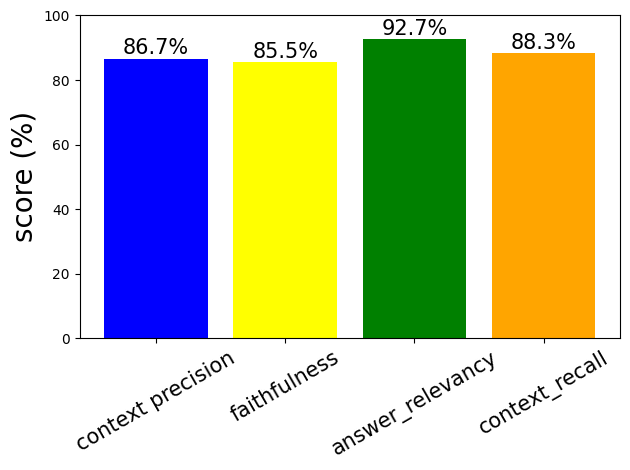

In [23]:
import matplotlib.pyplot as plt
myCol = [result['context_precision'], result['faithfulness'], result['answer_relevancy'], result['context_recall']]
for i in range(4):
    myCol[i] = myCol[i]*100
cate = ['context precision', 'faithfulness', 'answer_relevancy', 'context_recall']
myRow = [1,2,3,4]
colors = ['blue','yellow','green','orange']
plt.bar(myRow, myCol, tick_label=cate, color=colors)
for i, value in enumerate(myCol):
    plt.text(myRow[i], value + 0.1, str(round(value, 1)) + "%", ha='center', va='bottom', size=15)
plt.ylabel("score (%)", size=20)
plt.xticks(size=15, rotation=30)
plt.ylim([0,100])
plt.tight_layout()